In [2]:
import numpy as np
import random
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 10
n_layers=1
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state
def hamiltonian(n_qubits, edges, seed):
    np.random.seed(seed)
    weights = np.random.uniform(0.2, 0.8, len(edges))
    
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    for (idx, (i, j)) in enumerate(edges):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[j] = Z
        term = weights[idx] * kron_n(*ops)
        H += term

    return H, weights
def print_symbolic_hamiltonian(edges, weights):
    print("H = ", end="")
    terms = []
    for (i, j), w in zip(edges, weights):
        terms.append(f"{w:.3f} * Z[{i}]Z[{j}]")
    print(" + ".join(terms))
def ansatz(theta, n_qubits, edges, n_layers):
    state = initial_state(n_qubits)
    param_idx = 0

    for _ in range(n_layers):
        # Apply RY rotation to each qubit
        for i in range(n_qubits):
            angle = theta[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs based on Hamiltonian structure
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)
    state = state / np.linalg.norm(state)
    return state

def generate_random_edges(n_qubits, n_edges, seed):
    random.seed(seed)
    all_possible_edges = [(i, j) for i in range(n_qubits) for j in range(i + 1, n_qubits)]
    edges = random.sample(all_possible_edges, min(n_edges, len(all_possible_edges)))
    return edges




In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_qubit_connectivity(n_qubits, edges,seed):
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed)  # Force-directed layout
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray', width=2)
    plt.title("Qubit Connectivity Graph (Based on Hamiltonian Edges)")
    plt.show()



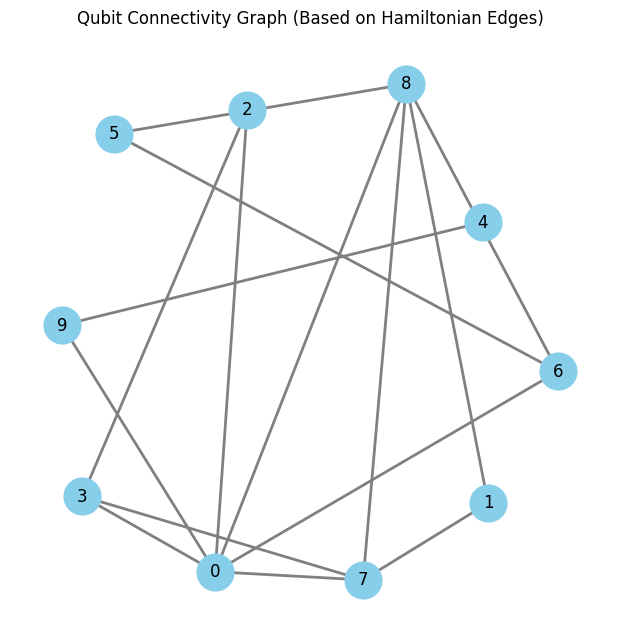

In [4]:
n_qubits = 10
n_edges = 15
seed = 42   
n_layers = 4
pdim=n_layers*n_qubits
edges = generate_random_edges(n_qubits, n_edges, seed)
visualize_qubit_connectivity(n_qubits, edges,seed)


In [5]:
def expectation(theta, H, n_qubits, n_layers):
    psi = ansatz(theta, n_qubits,edges, n_layers)
    return np.real(np.vdot(psi, H @ psi))
H, weights = hamiltonian(n_qubits, edges, seed)
print_symbolic_hamiltonian(edges, weights)
def cost(theta):
    return expectation(theta, H, n_qubits,n_layers)


H = 0.425 * Z[6]Z[8] + 0.770 * Z[0]Z[8] + 0.639 * Z[0]Z[2] + 0.559 * Z[2]Z[3] + 0.294 * Z[1]Z[8] + 0.294 * Z[1]Z[7] + 0.235 * Z[0]Z[9] + 0.720 * Z[0]Z[7] + 0.561 * Z[4]Z[9] + 0.625 * Z[0]Z[6] + 0.212 * Z[3]Z[7] + 0.782 * Z[0]Z[3] + 0.699 * Z[7]Z[8] + 0.327 * Z[5]Z[6] + 0.309 * Z[5]Z[8]


In [8]:
#Optimising using Nelder-Mead algorithm
def nelder_mead(f, x_start, step=0.5, tol=1e-3, max_iter=300):
    n = len(x_start)
    # Initialize simplex
    f_history = []
    simplex = [x_start]
    for i in range(n):
        x = np.array(x_start, dtype=float)
        x[i] += step
        simplex.append(x)
    simplex = np.array(simplex)
    #$print(simplex)
    for iteration in range(max_iter):
        # Sort simplex points by function value
        simplex = sorted(simplex, key=f)
        f_values = [f(x) for x in simplex]

        # Check convergence
        if np.std(f_values) < tol:
            break

        # Compute centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        xr = centroid + (centroid - simplex[-1])
        fr = f(xr)

        if f_values[0] <= fr < f_values[-2]:
            simplex[-1] = xr
        elif fr < f_values[0]:
            # Expansion
            xe = centroid + 2 * (xr - centroid)
            fe = f(xe)
            simplex[-1] = xe if fe < fr else xr
        else:
            # Contraction
            xc1 = simplex[-1] + 0.25 * (xr-simplex[-1] )   
            xc3 = simplex[-1] + 0.75 * (xr-simplex[-1] )
            fc1 = f(xc1)
            fc3 = f(xc3)
            xc = 0
            fc = 0
            if fc1 < fc3:
                xc,fc= xc1,fc1
            else:
                xc,fc = xc3,fc3
            if fc < f_values[-1]:
                simplex[-1] = xc1
            else:
                # Shrink
                for i in range(1, len(simplex)):
                    simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])
        print("function value at iteration", iteration, ":", f_values[0])
        f_history.append(f_values[0])
    best = min(simplex, key=f)
    return best, f(best), iteration + 1,f_history


x0 = np.random.uniform(0, 2 * np.pi,pdim)  # Initial guess
solnm, fval, iters,fhisto = nelder_mead(cost, x0)
print("[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", fval)
print("[Nelder-Mead] Optimal θ:", solnm)
print("[Nelder-Mead] Iterations:", iters)


function value at iteration 0 : -0.43284306795664496
function value at iteration 1 : -1.2339788086617565
function value at iteration 2 : -1.2339788086617565
function value at iteration 3 : -1.2339788086617565
function value at iteration 4 : -1.2339788086617565
function value at iteration 5 : -1.2339788086617565
function value at iteration 6 : -1.2339788086617565
function value at iteration 7 : -1.2339788086617565
function value at iteration 8 : -1.2339788086617565
function value at iteration 9 : -1.2339788086617565
function value at iteration 10 : -1.2339788086617565
function value at iteration 11 : -1.2339788086617565
function value at iteration 12 : -1.2339788086617565
function value at iteration 13 : -1.2339788086617565
function value at iteration 14 : -1.2339788086617565
function value at iteration 15 : -1.2339788086617565
function value at iteration 16 : -1.2339788086617565
function value at iteration 17 : -1.2339788086617565
function value at iteration 18 : -1.2339788086617565
fu

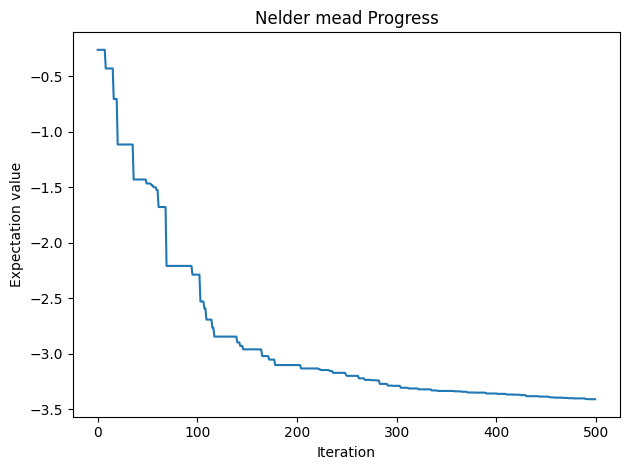

In [ ]:
plt.plot(fhisto)
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.title('Nelder mead Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [18]:
def sample_bitstrings(statevector, n_samples):
    probs = np.abs(statevector) ** 2
    assert np.isclose(np.sum(probs), 1.0), "Probabilities must sum to 1"
    outcomes = np.random.choice(len(probs), size=n_samples, p=probs) 
    bitstrings = [format(i, f'0{n_qubits}b') for i in outcomes]
    return bitstrings
theta = [ 2.25256276 , 3.25202022,  4.40417066,  2.13405592,  5.81759761,  5.90532417,
  1.89938636 , 3.26840561  ,1.73034456 , 1.84764971, -0.18819744 , 4.08844757,
  3.43467758 , 0.32877429,  1.96423821 , 5.19675177,  1.49233742 , 1.03424241,
  3.13170341 , 6.23225995 ,-0.06834839 , 4.23286075 , 4.9406749  , 1.76273354,
  4.03603722 , 2.19848651 , 3.90878054 , 4.23410058 , 3.24741843,  0.0864121,
  5.96553136  ,2.37874156 , 1.04027605 ,-0.06121572 , 3.9002107  , 4.43616051,
  0.3245757  , 3.83584196  ,1.57182783 , 4.50018004] # example parameters
state = ansatz(theta, n_qubits, edges, n_layers)
bitstrings = sample_bitstrings(state , 1000)
print(bitstrings)
print("Sampled bitstrings:", len(bitstrings))



['1000110010', '1110110000', '1100110110', '1001110010', '1000100010', '1000100010', '0001101111', '1110100010', '1001110010', '1010110010', '0001101111', '1110110000', '1110100000', '1000100010', '1000100010', '1000100010', '1000100010', '1000111000', '1000110010', '1000100010', '1001110100', '0111101101', '1000100010', '1000110010', '1000110010', '1110100000', '1000100010', '1000110010', '1001110010', '0001101111', '1001110010', '1000100010', '0001111101', '1110110000', '1110110000', '1110100000', '1000100010', '0101101011', '1010110010', '1000110010', '0111101101', '1000110010', '0001101111', '1110110000', '1000100010', '1010100010', '1000100010', '1000110010', '1001100010', '1000100010', '1110110000', '1110100000', '1110110000', '1110110000', '1001110010', '1110110000', '0011111111', '1000100010', '0001101111', '1000100010', '1000110010', '1000100010', '1110100000', '1000110010', '1000100010', '1001100010', '0111101101', '1110100000', '0011101111', '1110110110', '1110100000', '1000

In [19]:
def hamiltonian(n_qubits, seed):
    np.random.seed(seed)
    # Build symbolic Hamiltonian: (weight, [i, j]) for ZZ terms
    weights2 = [round(x, 3) for x in weights]
    hamiltonian_terms = [(weights[k], [i, j]) for k, (i, j) in enumerate(edges)]
    return hamiltonian_terms
hamiltonian_terms=hamiltonian(n_qubits, seed) 


In [20]:
def estimate_expectation(bitstrings, hamiltonian_terms):
    total = 0
    for bitstring in bitstrings:
        val = 0
        for coeff, qubits in hamiltonian_terms:
            product = 1
            for q in qubits:
                product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
            val += coeff * product
        total += val
    return total / len(bitstrings)
expect_val = estimate_expectation(bitstrings, hamiltonian_terms)
print("Estimated ⟨H⟩ =", expect_val)
def bitstring_energy(bitstring, hamiltonian_terms):
    val = 0
    for coeff, qubits in hamiltonian_terms:
        product = 1
        for q in qubits:
            product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
        val += coeff * product
    return val


Estimated ⟨H⟩ = -2.6793445997765333


In [21]:
from collections import Counter
bitstring_counts = Counter(bitstrings)
bitstring_data = []
for bitstring, count in bitstring_counts.items():
    energy = bitstring_energy(bitstring, hamiltonian_terms)
    bitstring_data.append((bitstring, count, energy))
print(bitstring_data)


[('1000110010', 173, -3.1617489278669364), ('1110110000', 124, -3.499607619896217), ('1100110110', 3, -0.16088540860054712), ('1001110010', 28, -3.1409486794639503), ('1000100010', 183, -3.1251319557015256), ('0001101111', 51, -2.378269605804366), ('1110100010', 1, -2.965100462436803), ('1010110010', 29, -3.0017463787296945), ('1110100000', 114, -2.2266107264337647), ('1000111000', 13, -1.4301484925467403), ('1001110100', 34, -2.5864059529751695), ('0111101101', 43, -2.040410913775086), ('0001111101', 1, -1.8437624483449522), ('0101101011', 10, -2.175268424458989), ('1010100010', 32, -2.9651294065642837), ('1001100010', 28, -3.1043317072985395), ('0011111111', 2, -1.2652752614791556), ('0011101111', 17, -2.538272154941608), ('1110110110', 3, -0.000882859463304797), ('0000101111', 4, -0.12068899532849131), ('1100110100', 1, -3.4566379318155622), ('0011101110', 2, -3.18990983443162), ('1001111000', 2, -1.4093482441437537), ('1010111000', 3, -1.2701459434094984), ('1000110110', 1, -1.3353

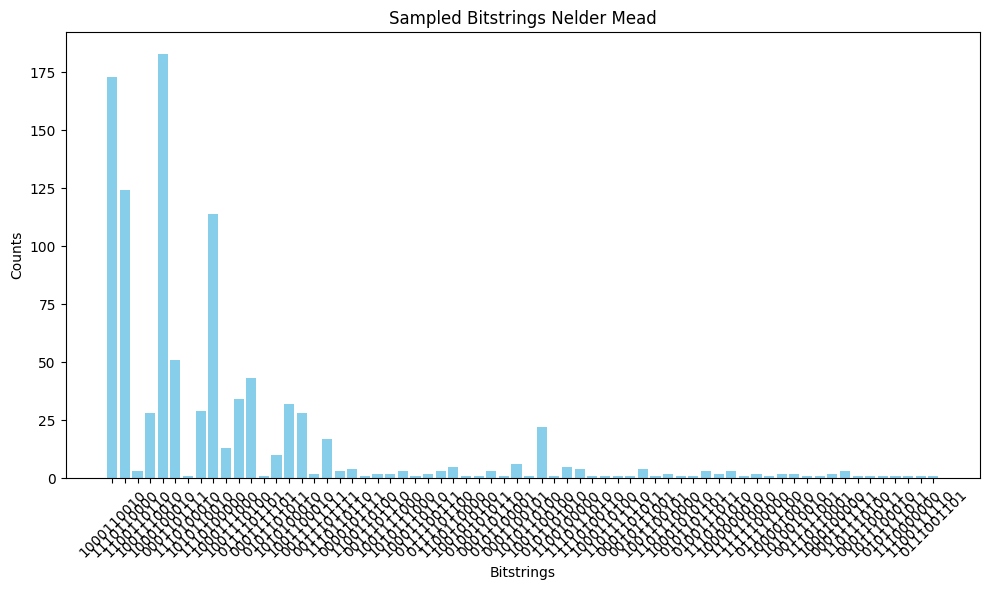

In [22]:
bitstrings_unique = list(bitstring_counts.keys())
frequencies = list(bitstring_counts.values())
plt.figure(figsize=(10,6))
plt.bar(bitstrings_unique, frequencies, color='skyblue')
plt.xlabel('Bitstrings')
plt.ylabel('Counts')
plt.title('Sampled Bitstrings Nelder Mead')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
